# PyMC3 experiments

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pymc3 as pm
import arviz as az

/home/anatoly/miniconda3/envs/rs-model/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import statsmodels.api as sm

In [4]:
from regime_switching.generate.arx import VARXGenerator

In [5]:
gen1 = VARXGenerator.random_model(n=1, m=0, p_max=3, p_portion=1, random_state=12)
display(gen1.coef_ar_df)
display(gen1.covariance)

,,0
lag,,
1,0,0.300609
2,0,-0.478138
3,0,0.878121


,0
0,0.202381


In [6]:
y1 = gen1.generate(100)[0]

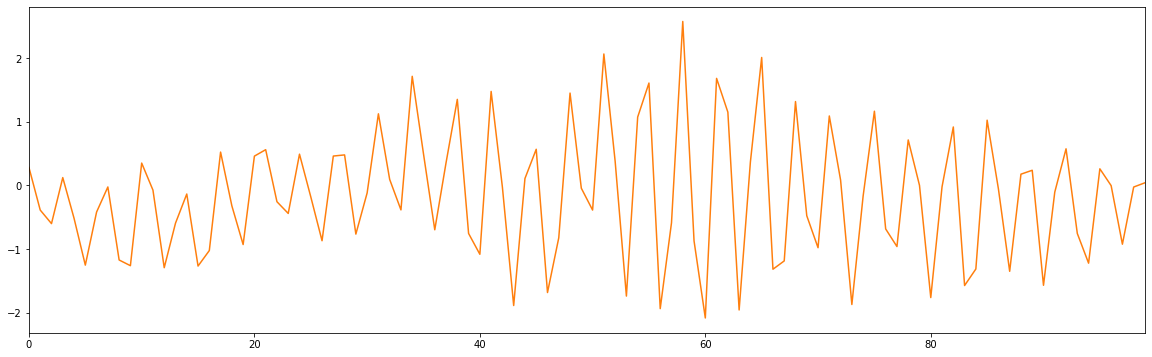

In [10]:
y1.plot.line(figsize=(20, 6), color='C1');

# Fit AR models

## Statsmodels

In [17]:
m1_full_eh = sm.tsa.AR(y1).fit(maxlag=3)

In [15]:
m1_full = sm.tsa.SARIMAX(y1, order=(3, 0, 0)).fit()

In [16]:
m1_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 -47.292
Date:                Sun, 25 Aug 2019   AIC                            102.583
Time:                        13:27:16   BIC                            113.004
Sample:                             0   HQIC                           106.800
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3621      0.052      6.951      0.000       0.260       0.464
ar.L2         -0.4695      0.043    -11.012      0.000      -0.553      -0.386
ar.L3          0.8553      0.046     18.450      0.000       0.764       0.946
sigma2         0.1437      0.023      6.136      0.000       0.098       0.190
===================================================================================
Ljung-Box (Q):                       43.99   Jarque-Bera (JB):                 5.28
Prob(Q):                              0.31   Prob(JB):                         0.07
Heteroskedasticity (H):               1.37   Skew:                             0.56
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## PyMC3

In [32]:
p = 3

with pm.Model() as ar3_model:
    # NOTE: Can specify a prior with [-1; 1] bounding :) 
    ar_coeffs = pm.Normal('ar_coeffs', shape=(p), mu=0, sd=10**4)
    sigma = pm.HalfNormal('sigma', sd=10**4)
    # no intercept
    
    obs_y = pm.Data('obs_y', y1)
    y_llh = pm.AR('y', rho=ar_coeffs, sigma=sigma, constant=False, observed=obs_y)

In [33]:
with ar3_model:
    prior = pm.sample_prior_predictive()
    trace = pm.sample(500, tune=500, chains=2)
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, ar_coeffs]
Sampling 2 chains: 100%|██████████| 2000/2000 [02:47<00:00,  7.06draws/s]
The acceptance probability does not match the target. It is 0.88030346551082, but should be close to 0.8. Try to increase the number of tuning steps.


In [37]:
inf_data = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={'lag': range(1, p+1)},
    dims={'ar_coeffs':['lag']}
)

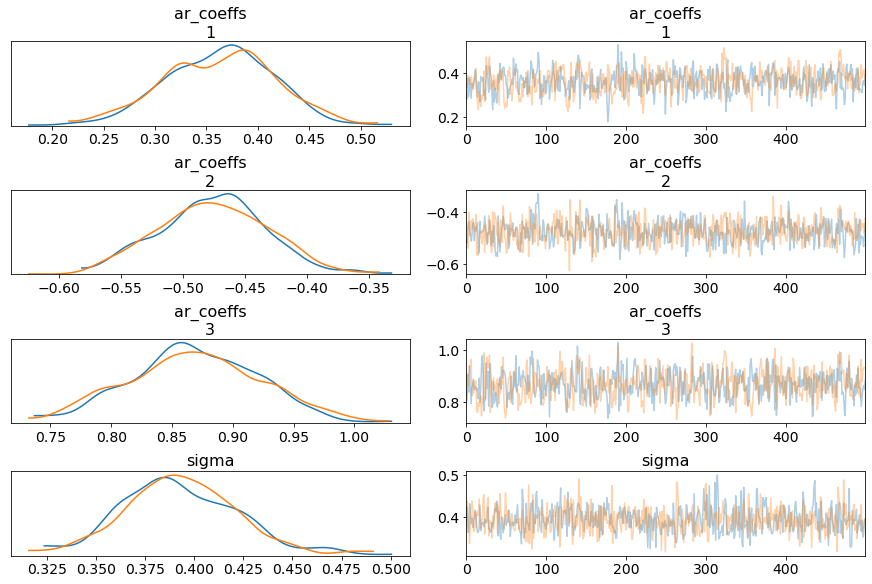

In [40]:
az.plot_trace(inf_data);

In [39]:
inf_data.posterior

<xarray.Dataset>
Dimensions:    (chain: 2, draw: 500, lag: 3)
Coordinates:
  * chain      (chain) int64 0 1
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * lag        (lag) int64 1 2 3
Data variables:
    ar_coeffs  (chain, draw, lag) float64 0.3088 -0.5101 ... -0.4243 0.9327
    sigma      (chain, draw) float64 0.3819 0.4228 0.3627 ... 0.3947 0.3944
Attributes:
    created_at:                 2019-08-25T10:53:22.796260
    inference_library:          pymc3
    inference_library_version:  3.7

## Compare coeffs

In [43]:
coeffs = inf_data.posterior.mean(dim=['chain', 'draw'])
coeffs

<xarray.Dataset>
Dimensions:    (lag: 3)
Coordinates:
  * lag        (lag) int64 1 2 3
Data variables:
    ar_coeffs  (lag) float64 0.3622 -0.4763 0.8682
    sigma      float64 0.3933

In [44]:
display(gen1.coef_ar_df)
display(gen1.covariance)

,,0
lag,,
1,0,0.300609
2,0,-0.478138
3,0,0.878121


,0
0,0.202381


In [50]:
m1_full.params

ar.L1     0.362122
ar.L2    -0.469461
ar.L3     0.855268
sigma2    0.143655
dtype: float64

# VAR models

In [51]:
var1 = VARXGenerator.random_model(n=2, m=0, p_max=3, p_portion=1, random_state=12)
display(var1.coef_ar_df)
display(var1.covariance)

0         1
lag                      
1   0  0.652201 -0.258925
    1  0.646841 -0.468785
2   0 -0.297185 -0.325590
    1 -0.035154  0.507179
3   0  0.206845  0.724252
    1 -0.065620  0.599689

,0,1
0,0.935261,0.895872
1,0.895872,1.047353


In [52]:
z1 = var1.generate(100)

## PyMC3

TODO! Currently have just a "fake" Multivariate AR.

Need to somehow make my own:

https://discourse.pymc.io/t/multivariate-time-series-inference/2799/3

https://discourse.pymc.io/t/ma-model-for-time-series-prediction/2617

Reference material:

https://docs.pymc.io/api/distributions/timeseries.html#pymc3.distributions.timeseries.MvGaussianRandomWalk

https://github.com/pymc-devs/pymc3/blob/master/pymc3/distributions/timeseries.py

https://github.com/pymc-devs/pymc3/blob/master/pymc3/distributions/multivariate.py

Other cool stuff:

https://barnesanalytics.com/bayesian-time-varying-coefficients-in-pymc3

https://github.com/RJTK/pymc3-kalman



In [70]:
p = 3
n = 2

with pm.Model() as var3_model:
    # NOTE: Can specify a prior with [-1; 1] bounding :) 
    ar_coeffs = pm.Normal('ar_coeffs', shape=(p, n), mu=0, sd=10**4)
    
    # Sigma approximated by Cholesky factor of covariance
    sd_dist = pm.HalfNormal.dist(shape=n, sd=10**4)
    sigma_packed = pm.LKJCholeskyCov('sigma_packed', eta=1, n=n, sd_dist=sd_dist)
    sigma = pm.Deterministic('sigma', pm.expand_packed_triangular(n=n, packed=sigma_packed, lower=True))

    # no intercept
    
    obs_y = pm.Data('obs_y', z1)
    # y_llh = pm.AR('y', rho=ar_coeffs, sigma=sigma, constant=False, observed=obs_y)

    mu = pm.Normal('mu', shape=n, mu=0, sd=10**4)
    y_mv = pm.MvNormal('y', mu=mu, chol=sigma, observed=obs_y)

/home/anatoly/miniconda3/envs/rs-model/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/anatoly/miniconda3/envs/rs-model/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [71]:
with var3_model:
    prior = pm.sample_prior_predictive()
    trace = pm.sample(500, tune=500)
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
/home/anatoly/miniconda3/envs/rs-model/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma_packed, ar_coeffs]
INFO:pymc3:NUTS: [mu, sigma_packed, ar_coeffs]
100%|██████████| 2000/2000 [00:19<00:00, 103.83it/s]


In [75]:
inf_data = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={'lag': range(1, p+1), 'v_dim': range(n)},
    dims={'ar_coeffs':['lag', 'v_dim'], 'mu':['v_dim'], 'sigma': ['v_dim', 'v_dim']}
)

In [76]:
inf_data.posterior

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 500, lag: 3, sigma_packed_dim_0: 3, v_dim: 2)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * lag                 (lag) int64 1 2 3
  * v_dim               (v_dim) int64 0 1
  * sigma_packed_dim_0  (sigma_packed_dim_0) int64 0 1 2
Data variables:
    ar_coeffs           (chain, draw, lag, v_dim) float64 -3.946e+03 ... -1.404e+04
    mu                  (chain, draw, v_dim) float64 -0.7623 -1.449 ... -1.399
    sigma_packed        (chain, draw, sigma_packed_dim_0) float64 1.257 ... 1.269
    sigma               (chain, draw, v_dim, v_dim) float64 1.257 0.0 ... 1.269
Attributes:
    created_at:                 2019-08-25T13:30:58.057411
    inference_library:          pymc3
    inference_library_version:  3.7

In [77]:
coeffs = inf_data.posterior.mean(dim=['chain', 'draw'])
coeffs

<xarray.Dataset>
Dimensions:             (lag: 3, sigma_packed_dim_0: 3, v_dim: 2)
Coordinates:
  * lag                 (lag) int64 1 2 3
  * v_dim               (v_dim) int64 0 1
  * sigma_packed_dim_0  (sigma_packed_dim_0) int64 0 1 2
Data variables:
    ar_coeffs           (lag, v_dim) float64 78.53 13.41 -52.4 ... -56.08 112.4
    mu                  (v_dim) float64 -0.5517 -1.193
    sigma_packed        (sigma_packed_dim_0) float64 1.182 0.8368 1.235
    sigma               (v_dim, v_dim) float64 1.182 0.0 0.8368 1.235

In [78]:
display(var1.coef_ar_df)
display(var1.covariance)

0         1
lag                      
1   0  0.652201 -0.258925
    1  0.646841 -0.468785
2   0 -0.297185 -0.325590
    1 -0.035154  0.507179
3   0  0.206845  0.724252
    1 -0.065620  0.599689

,0,1
0,0.935261,0.895872
1,0.895872,1.047353
